In [1]:
import tkinter as tk
from PIL import Image, ImageTk
from tkinter import simpledialog
import pandas as pd
import random
from itertools import product
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

### Card

In [2]:
# ranks:
# 1 -> Ace
# 2-10 -> 2-10
# 11 -> J
# 12 -> Q
# 13 -> K

class Card:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
        if self.rank == 1:
            self.card_scores = [1, 11]
        elif self.rank >= 11 and self.rank <= 13:
            self.card_scores = [10, 10]
        else:
            self.card_scores = [self.rank, self.rank]

        if self.rank == 1:
            self.short_rank = 'A'
        elif self.rank == 11:
            self.short_rank = 'J'
        elif self.rank == 12:
            self.short_rank = 'Q'
        elif self.rank == 13:
            self.short_rank = 'K'
        else:
            self.short_rank = str(self.rank)

        if self.suit == 'Spades':
            self.short_suit = 'S'
        elif self.suit == 'Hearts':
            self.short_suit = 'H'
        elif self.suit == 'Clubs':
            self.short_suit = 'C'
        else:
            self.short_suit = 'D'

        self.image_location = 'static/images/{}{}.png'.format(
            self.short_rank, self.short_suit)

    def __repr__(self):
        if self.rank == 1:
            true_rank = 'Ace'
        elif self.rank == 11:
            true_rank = 'Jack'
        elif self.rank == 12:
            true_rank = 'Queen'
        elif self.rank == 13:
            true_rank = 'King'
        else:
            true_rank = str(self.rank)
        return '{} of {}'.format(true_rank, self.suit)

suits = ('Spades', 'Hearts', 'Clubs', 'Diamonds')

### Deck

In [3]:
class Deck:
    def __init__(self, number_of_decks):
        self.number_of_decks = number_of_decks
        self.cards = []
        self.create(self.number_of_decks)
        self.cards_drawn = []
        self.count = 0
        self.true_count = 0

    def __repr__(self):
        return 'Game deck has {} cards remaining'.format(len(self.cards))

    def calculate_count(self):
        self.count = 0
        self.true_count = 0
        for card in self.cards_drawn:
            if card.rank in [1, 10, 11, 12, 13]:
                self.count -= 1
            if card.rank in [2, 3, 4, 5, 6]:
                self.count += 1
        self.true_count = self.count/round(len(self.cards)/52)

    def create(self, number_of_decks):
        decks = [Card(rank, suit) for suit in suits for rank in range(1, 14)
                 for deck in range(number_of_decks)]
        decks = random.sample(decks, len(decks))
        self.cards.extend(decks)

    def create_test_deck(self,cards):
        self.cards = []
        for card in cards:
            self.cards.append(card)
    
    def draw(self):
        drawn_card = self.cards[0]
        self.cards.remove(self.cards[0])
        self.cards_drawn.append(drawn_card)
        return drawn_card

    def reset(self):
        self.cards = []
        self.create(self.number_of_decks)

### Hand

In [4]:
class Hand:
    def __init__(self,rules,bet):
        self.hand_cards = []
        self.score = [0,0]
        self.options = []
        self.rules = rules
        self.hand_bet = bet
        self.blocked = False
        
    def calculate_score(self):
        # loop over all cards in hand
        self.score = [0,0]
        all_scores = []
        for card in self.hand_cards:
            all_scores.append(card.card_scores)
            
        self.score = sorted(list({sum(combination) for 
                                  combination in 
                                  product(*all_scores)}))[0:2]
        if len(self.score) < 2:
            self.score.append(self.score[0])
            
        #if self.score[0] == self.score[1]:
            #print('Current Hand score: {0}'.format(self.score[0]))
        #elif self.score[1] > 21:
            #print('Current Hand score: {0}'.format(self.score[0]))
        #else:
            #print('Current Hand score: {0} or {1}'.format(self.score[0], self.score[1]))

    def calculate_options(self):
        self.options = []
        if not self.blocked:
            if len(self.hand_cards) == 2: #initial possibilities after first draw
                if self.score[1] == 21:
                    return
                if self.rules.doublesoft:
                    if any(x in self.score for x in self.rules.doubledown):
                        self.options.append('doubledown')
                else:
                    if self.score[1] in self.rules.doubledown:
                        self.options.append('doubledown')
                if self.hand_cards[0].card_scores[0] == self.hand_cards[1].card_scores[0]:
                    self.options.append('split')
                if self.score[0] <= 21:
                    self.options.append('hit')
                self.options.append('stand')
            else: #after other actions have been taken
                if self.score[0] > 21:
                    self.options = ['BUST']
                if self.score[0] <= 21:
                    self.options.append('hit')
                    self.options.append('stand')
        #print(self.options)

    def calculate_hand_bet(self):
        print(self.hand_bet)
        
    def show_hand_cards(self):
        print(self.hand_cards)

    def hit(self,deck,num_cards):
        for i in range(0,num_cards):
            self.hand_cards.append(deck.draw())
        self.calculate_score()
        #self.show_hand_cards()
        self.calculate_options()
        #self.calculate_hand_bet()
        
    def stand(self):
        self.calculate_score()
        #self.show_hand_cards()
        self.options = ['none']
        #self.calculate_hand_bet()

    def doubledown(self,deck):
        self.hand_bet = 2*self.hand_bet
        self.hand_cards.append(deck.draw())
        self.calculate_score()
        if self.score[0] > 21:
            self.options = ['BUST']
        else:
            self.options = ['none']
        #self.show_hand_cards()
        #print(self.options)
        #self.calculate_hand_bet()
    
    def show_options(self):
        return self.options


### Player

In [5]:
class Player:
    def __init__(self,rules):
        self.funding = 0
        self.hands = []
        self.score = [0,0]
        self.rules = rules
        self.options = []

    def refund(self,funds):
        self.funding = funds
    
    def initiate(self, deck, bet):
        self.options = []
        self.bet = bet
        self.reset_hands()
        if self.add_hand():
            self.hands[0].hit(deck,2)
    
            if any(x in self.hands[0].score for x in [21]): #in case of blackjack no more options can be done
                self.options = ['blackjack']
                #print('blackjack on initial')

    def check_funds(self):
        #print('checking funds')
        if self.bet <= self.funding:
            return True
        else:
            return False
    
    def add_hand(self):
        if self.check_funds():
            self.update_funds()
            hand = Hand(self.rules, self.bet)
            self.hands.append(hand)
            return True
        else:
            print('insufficient funds')
            return False

    def update_funds(self):
        self.funding = self.funding - self.bet
        #print("funding after bet {}".format(self.funding))

    def show_options(self, hand_index):
        print(self.hands[hand_index].options)

    def hit(self, deck, hand_index):
        time.sleep(0.3)
        self.hands[hand_index].hit(deck,1)

    def stand(self, hand_index):
        self.hands[hand_index].stand()

    def doubledown(self, deck, hand_index):
        if self.check_funds:
            self.hands[hand_index].doubledown(deck)
            self.hands[hand_index].blocked = True
            self.update_funds()
        else:
            print('insufficient funds for doubledown')

    def split(self, deck, hand_index):
        if self.check_funds:
            if len(self.hands) < self.rules.splitnumber:
                keep_card = self.hands[hand_index].hand_cards[0]
                transfer_card = self.hands[hand_index].hand_cards[1]
    
                hand = Hand(self.rules, self.bet)
                self.hands[hand_index].hand_cards = []
                self.hands.append(hand)
    
                index_new_hand = len(self.hands) - 1
    
                self.hands[hand_index].hand_cards.append(keep_card)
                self.hands[index_new_hand].hand_cards.append(transfer_card)

                if keep_card.rank == 1:
                    #print('block splitted Aces')
                    self.hands[hand_index].blocked = True
                    self.hands[index_new_hand].blocked = True
                self.hands[hand_index].hit(deck, 1)
                self.hands[index_new_hand].hit(deck, 1)
                self.update_funds()
            else:
                print('maximum number of parallel hands reached')
        else:
            print('insufficient funds for split')
    
    def reset_hands(self):
        self.hands = []

### Dealer

In [6]:

class Dealer:
    def __init__(self,rules):
        self.hand_cards = []
        self.score = [0,0]
        self.options = []
        self.rules = rules
        
    def calculate_score(self, initial = False):
        # loop over all cards in hand
       
        if initial:
            self.score = [0,0]
            self.score[0] += self.hand_cards[0].card_scores[0]
            self.score[1] += self.hand_cards[0].card_scores[1]
        else:
            self.score = [0,0]
            all_scores = []
            for card in self.hand_cards:
                all_scores.append(card.card_scores)
                
            self.score = sorted(list({sum(combination) for 
                                      combination in 
                                      product(*all_scores)}))[0:2]
            if len(self.score) < 2:
                self.score.append(self.score[0])
        
        #if self.score[0] == self.score[1]:
            #print('Current Hand score: {0}'.format(self.score[0]))
        #elif self.score[1] > 21:
            #print('Current Hand score: {0}'.format(self.score[0]))
        #else:
            #print('Current Hand score: {0} or {1}'.format(self.score[0], self.score[1]))     
    
    def initiate(self, deck):
        self.reset_hand()
        self.hand_cards.append(deck.draw())
        self.hand_cards.append(deck.draw())

        self.calculate_score(initial = True)
        
        if self.hand_cards[0].rank in [1, 10, 11, 12, 13] and self.rules.peek:
            if self.hand_cards[0].card_scores[1] + self.hand_cards[1].card_scores[1] == 21:
                self.options = ['blackjack']
                #print(self.hand_cards)
            else:
                self.options = ['dealer ready']
                #print(self.hand_cards[0])
        else:
            self.options = ['dealer ready']
            #print(self.hand_cards[0])
        #print(self.options)
        
    def reveal(self):
        self.calculate_score()
        self.calculate_options()
    
    def hit(self, deck):
        self.hand_cards.append(deck.draw())

        self.calculate_score()
        self.calculate_options()
    
    def calculate_options(self):
        self.options = []
        if len(self.hand_cards) == 2 and self.score[1] == 21:
            self.options.append('blackjack')
        else:
            if self.score[0] == self.score[1]:
                if self.score[0] < 17:
                    self.options.append('hit')
                elif 17 <= self.score[0] <= 21:
                    self.options.append('none')
                else:
                    self.options.append('BUST')
            else:
                if 17 <= self.score[1] <= 21:
                    self.options.append('none')
                elif 17 <= self.score[0] <= 21:
                    self.options.append('none')
                elif self.score[0] > 21:
                    self.options.append('BUST')
                else:
                    self.options.append('hit')
        #print(self.options)
        
    def reset_hand(self):
        self.hand_cards = []

### Game

In [27]:
class Rules:
    def __init__(self):
        self.dealersoft17 = 'stand' #instert 'stand' or 'hit' for dealer on soft 17
        self.blackjack = 1.5 #insert multiplier in case of Blackjack on initial hand
        self.doubledown = [9,10,11] #insert ranks of cards that can be doubled
        self.doublesoft = False
        self.doubleaftersplit = True #insert if Player can double after split
        self.actionaftersplit = False #insert if Player can split Aces
        self.splitnumber = 3 #insert how many parallel sets Player can have
        self.peek = False
        self.num_of_decks = 8
        self.deck_penetration = 0.3
        self.test_deck = False

In [28]:
class Game:
    def __init__(self, rules, player, dealer, num_of_decks):
        self.rules = rules
        self.player = player
        self.dealer = dealer
        self.num_of_decks = num_of_decks
        self.deck = Deck(self.num_of_decks)
        self.result = []
        self.round_bet = 0
        self.reveal_dealer = False

    def check_penetration(self):
        if len(self.deck.cards) < self.num_of_decks*52*self.rules.deck_penetration:
            print('shuffle')
        else:
            print('{} cards left'.format(len(self.deck.cards)))

    def start_round(self, bet):
        self.eval = 0
        self.result = []
        self.reveal_dealer = False
        if 0 < bet <= self.player.funding:
            #print('round started successfully')
            self.round_bet = bet
            self.player.initiate(self.deck, bet)
            self.dealer.initiate(self.deck)
    
            if 'blackjack' in self.dealer.options:
                if 'blackjack' in self.player.options:
                    self.result.append('push on initial')
                else:
                    self.result.append('player lost on dealer blackjack')
                self.evaluate()
            elif 'blackjack' in self.player.options:
                self.dealer.reveal()
                if self.dealer.score[1] == 21:
                    self.result.append('push on initial')
                    self.evaluate()
                else:
                    self.result.append('player won on initial blackjack')
                    self.dealer_turn()
            else:
                self.player_turn()
        else:
            print('insufficient funds')
            
    def player_turn(self):
        number_of_hands = len(self.player.hands)
        hand_count = 0
        for hand in self.player.hands:
            hand_index = self.player.hands.index(hand)
            if not any(x in ['BUST','none'] for x in hand.options):
                #print('hand nr. {} waiting for input. current options: {}'.format(hand_index, hand.options))
                pass
            else:
                #print('no more options for this hand')
                hand_count +=1
        if hand_count == number_of_hands:
            #print('player has no more options')
            self.player.options = ['none']
            self.dealer_turn()
                
    def dealer_turn(self):
        self.dealer.reveal()
        self.reveal_dealer = True
        while 'hit' in self.dealer.options:
            self.dealer.hit(self.deck)
        if 'blackjack' in self.dealer.options:
            self.result.append('dealer reveals blackjack')
        self.evaluate()

    def calculate_counting_score(self, scores):
        if scores[0] == scores[1]:
            return scores[0]
        else:
            try:
                return max(score for score in scores if score <= 21)
            except:
                return 22
            

    def evaluate(self):
        self.eval += 1
        #print('xxxxxxxxxxxxxxxxxxxxxx')
        if self.eval == 1:
            #print('evaluate nr.: {}'.format(self.eval))
            #print('funds before eval: {}'.format(self.player.funding))
            #print('dealer options: {}'.format(self.dealer.options))
            #print('player options: {}'.format(self.player.options))
            for hand in self.player.hands:
                hand_index = self.player.hands.index(hand)
                print('Player Cards hand {}: {}'.format(hand_index,hand.hand_cards))
                #print('player hand {} options: {}'.format(hand_index, hand.options))
                #print('Player {}'.format(hand.hand_cards))
                #print('Dealer {}'.format(self.dealer.hand_cards))
            
            wins = 0
            if self.result:
                if 'player won on initial blackjack' in self.result:
                    win = (self.rules.blackjack * self.round_bet) + self.round_bet
                    wins += win
                    #print('player blackjack:, win {}'.format(win))
                elif 'push on initial' in self.result:
                    win = self.round_bet
                    wins += win
                    #print('push on initial:, win {}'.format(win))
                elif 'player lost on dealer blackjack' in self.result:
                    #print('player lost on initial dealer blackjack')
                    pass
                elif 'dealer reveals blackjack' in self.result:
                    #print('player lost on late dealer blackjack')
                    pass
            else:
                dealer_score = self.calculate_counting_score(self.dealer.score)
                for hand in self.player.hands:
                    hand_index = self.player.hands.index(hand)
                    hand_score = self.calculate_counting_score(hand.score)
                    #print('evaluate hand {} hand score: {} dealer score: {}'.format(hand_index, hand_score, dealer_score))
    
                    if hand_score > 21:
                        #print('hand {} BUST'.format(hand_index))
                        pass
                    else:
                        if dealer_score > 21:
                            win = hand.hand_bet * 2
                            wins += win
                            #print('hand {} wins, win {}'.format(hand_index, win))
                        else:
                            if hand_score < dealer_score:
                                #print('hand {} lost'.format(hand_index))
                                pass
                            if hand_score == dealer_score:
                                win = hand.hand_bet
                                wins += win
                                #print('hand {} push, win {}'.format(hand_index, win))
                            if hand_score > dealer_score:
                                win = hand.hand_bet * 2
                                wins += win
                                #print('hand {} wins, win {}'.format(hand_index, win))
            print('Dealer Cards: {}'.format(self.dealer.hand_cards))
            self.player.funding += wins
            print('wins: {}'.format(wins))
            print('xxxxxxxxxxxxxxxxxxxxxx')
        self.deck.calculate_count()
        
        #print('Cards drawn: {}'.format(self.deck.cards_drawn))
        #print('Count: {}'.format(self.deck.count))

### App

In [23]:
class BettingApp:
    def __init__(self, root, test_deck, automated = False):
        self.root = root
        self.buttons = []
        self.image_labels = []
        self.score_labels = []
        self.bet_labels = []
        self.rules = Rules()
        self.test_deck = test_deck
        self.automated = automated
        self.setup_ui()
        

    def setup_ui(self):
        self.root.title("GUI with Placed Buttons")
        self.root.geometry("1200x720")
        self.load_background()

        self.funds = tk.StringVar(value="1000")
        self.bet = tk.StringVar(value="0")
        
        self.funds_label = tk.Label(self.root, textvariable=self.funds, font=('Arial', 16), bg='white')
        self.funds_label.place(relx=1.0, rely=0, x=-10, y=10, anchor='ne')

        self.bet_label = tk.Label(self.root, textvariable=self.bet, font=('Arial', 16), bg='lightblue')

        self.start_button = self.create_button("Start Game", self.start_game, 600, 450)
        self.rules_button = self.create_button("See Rules", self.see_rules, 50, 150, static = True)
        
        self.card_width = 80
        self.card_height = 116

    def load_background(self):
        bg_image_path = r"C:\Users\JanAllemann\repo\bj\static\visuals\table.jpg"
        try:
            bg_image = Image.open(bg_image_path)
            bg_image = bg_image.resize((1200, 720), Image.Resampling.LANCZOS)
            bg_photo = ImageTk.PhotoImage(bg_image)
            bg_label = tk.Label(self.root, image=bg_photo)
            bg_label.place(x=0, y=0, relwidth=1, relheight=1)
            self.bg_photo = bg_photo  # Keep a reference!
        except Exception as e:
            print(f"Failed to load background image: {e}")
    
    def create_button(self, text, command, x, y, static = False):
        button = tk.Button(self.root, text=text, command=command)
        button.place(x=x, y=y)
        if not static:
            self.buttons.append(button)
        return button

    def create_action_button(self, text, command, x, y):
        button = tk.Button(self.root, text=text, command=lambda: command())
        button.place(x=x, y=y)
        return button
    
    def wipe_button(self, button):
        button.place_forget()

    def wipe_all_buttons(self):
        for button in self.buttons:
            button.place_forget()

    def start_game(self):
        self.wipe_all_buttons()
        self.refund_button = self.create_button("Refund", self.refund, 50, 100)
        self.create_button("Deal", self.start_deal, 600, 450)
        self.create_button("Restart Game", self.setup_ui, 50 , 50, static = True)
        self.bet_label.place(x = 400, y = 690, anchor='ne')
        
        self.bet5_button = self.create_button("Bet +5", lambda: self.modify_bet(5), 50, 650)
        self.bet10_button = self.create_button("Bet +10", lambda: self.modify_bet(10), 120, 650)
        self.bet25_button = self.create_button("Bet +25", lambda: self.modify_bet(25), 190, 650)
        self.bet50_button = self.create_button("Bet +50", lambda: self.modify_bet(50), 260, 650)
        self.bet100_button = self.create_button("Bet +100", lambda: self.modify_bet(100), 330, 650)
        self.reset_bet_button = self.create_button("Reset Bet", self.reset_bet, 400, 650)

        self.player = Player(self.rules)
        self.dealer = Dealer(self.rules)
        self.game = Game(self.rules, self.player, self.dealer, num_of_decks = self.rules.num_of_decks)
        if self.rules.test_deck:
            self.game.deck.create_test_deck(self.test_deck)
        self.game.player.funding = float(self.funds.get())
        
        self.start_button.place_forget()
        #print('game initiated')  # Assuming game initialization
    def show_shuffle_label(self):
        self.shuffle_label = tk.Label(self.root, text = "Reshuffle", bg = "white", fg = "black", font=('Arial', 48))
        self.shuffle_label.place(x = 600, y = 450, anchor = 'center')

        self.root.after(2000, self.shuffle_label.destroy)
        
    def next_round(self):
        if len(self.game.deck.cards) < self.rules.num_of_decks * 52 * self.rules.deck_penetration:
            #print('reshuffle')
            self.game.deck = Deck(self.rules.num_of_decks)
            self.show_shuffle_label()
       
        self.wipe_all_buttons()
        self.refund_button = self.create_button("Refund", self.refund, 50, 100)
        self.create_button("Deal", self.start_deal, 600, 450)
        self.create_button("Restart Game", self.setup_ui, 50 , 50, static = True)
        self.bet_label.place(x = 400, y = 700, anchor='ne')
        
        self.bet5_button = self.create_button("Bet +5", lambda: self.modify_bet(5), 50, 650)
        self.bet10_button = self.create_button("Bet +10", lambda: self.modify_bet(10), 120, 650)
        self.bet25_button = self.create_button("Bet +25", lambda: self.modify_bet(25), 190, 650)
        self.bet50_button = self.create_button("Bet +50", lambda: self.modify_bet(50), 260, 650)
        self.bet100_button = self.create_button("Bet +100", lambda: self.modify_bet(100), 330, 650)
        self.reset_bet_button = self.create_button("Reset Bet", self.reset_bet, 400, 650)
        #print('round initiated')
        
    def see_rules(self):
        text_widget = tk.Text(self.root, width=40, height=15)
        text_widget.pack()
    
        # Inserting each attribute and its value into the Text widget
        for attr, value in self.rules.__dict__.items():
            text_widget.insert(tk.END, f"{attr}: {value}\n")
        self.hide_rules_button = self.create_button("Hide Rules", lambda: self.hide_rules(text_widget), 50, 150)

    def hide_rules(self, widget):
        widget.pack_forget()
        self.hide_rules_button.place_forget()
        self.rules_button = self.create_button("See Rules", self.see_rules, 50, 150, static = True)
            
    def refund(self):
        self.funds.set("0")
        response = simpledialog.askinteger("Input", "Enter refund amount:", parent=self.root)
        if response is not None:
            current_funds = float(self.funds.get())
            self.funds.set(str(current_funds + response))
            #print(f"Refund amount set to: {response}, Total funds: {self.funds.get()}")
            self.game.player.funding = float(self.funds.get())
        else:
            print("No refund amount entered")
    
    def start_deal(self):
        if int(self.bet.get()) > 0:
            self.game.start_round(int(self.bet.get()))
            self.funds.set(str(self.game.player.funding))
            self.wipe_all_buttons()
            self.bet_label.place_forget()

            if any(x in ['push on initial','player lost on dealer blackjack'] for x in self.game.result):
                self.button_end_round = self.create_button('End round', self.end_round, 600, 450)
                self.game.reveal_dealer = True
                self.read_and_display_cards()
            else:    
                self.read_and_display_cards(initial_deal = True)
                self.start_player_input()
        else:
            print("bet can't be 0")

    def end_round(self):
        self.funds.set(str(self.game.player.funding))
        self.wipe_images()
        self.wipe_scores()
        self.wipe_bets()
        self.next_round()
    
    def read_and_display_cards(self, initial_deal = False):
        dealer_score = []
        if not self.game.reveal_dealer:
            x_card = 0
            for card in self.game.dealer.hand_cards[0:1]:
                self.display_card(card = card, x = 600 + x_card, y = 150)
                dealer_score.append(card.card_scores)
                x_card += 50
        else:
            x_card = 0
            for card in self.game.dealer.hand_cards:
                self.display_card(card = card, x = 600 + x_card, y = 150)
                dealer_score.append(card.card_scores)
                x_card += 50
        self.display_score(dealer_score, 600, 300)
                
        x_hand = 0
        for hand in self.player.hands:
            hand_index = self.player.hands.index(hand)
            hand_score = []
            x_card = 0
            for card in hand.hand_cards:
                self.display_card(card = card, x = (150 + x_hand) + x_card, y = 350)
                x_card += 50
                hand_score.append(card.card_scores)
            self.display_score(hand_score, 150 + x_hand, 500)
            self.display_bet(hand.hand_bet, 150 + x_hand, 550)
            x_hand += 300
                
    def display_card(self, card, x, y):
        card_image = Image.open(card.image_location)
        card_image = card_image.resize((self.card_width, self.card_height), Image.Resampling.LANCZOS)
        # Convert the image for tkinter
        tk_photo = ImageTk.PhotoImage(card_image)
        
        # Create a label to display the image
        label = tk.Label(self.root, image=tk_photo)
        label.image = tk_photo  # Keep a reference!
        label.place(x=x, y=y)
        self.image_labels.append(label)

    def wipe_scores(self):
        for label in self.score_labels:
            label.place_forget()
        self.score_labels = []
        
    def display_score(self, all_scores, x, y):
        score = []
        score = sorted(list({sum(combination) for 
                                      combination in 
                                      product(*all_scores)}))[0:2]
        if len(score) < 2:
            score.append(score[0])
        
        if score[0] == score[1]:
            score = str(score[0])
        elif score[1] > 21:
            score = str(score[0])
        else:
            score = str(score[0]) + 'or' + str(score[1])
        label = tk.Label(self.root, text = score, bg = "white", fg = "black", font=('Arial', 16))
        label.place(x = x, y = y)
        self.score_labels.append(label)

    def wipe_bets(self):
        for label in self.bet_labels:
            label.place_forget()
        self.bet_labels = []
        
    def display_bet(self, bet, x, y):
        label = tk.Label(self.root, text = str(bet), bg = "white", fg = "black", font=('Arial', 16))
        label.place(x = x, y = y)
        self.bet_labels.append(label)        
        
    def wipe_images(self):
        for label in self.image_labels:
            label.place_forget()
        self.image_labels = []

    def read_and_display_options(self, hand, hand_index):
        options = []
        for option in hand.options:
            if option == "hit":
                self.create_button("Hit" + str(hand_index), lambda: self.hit(hand_index), hand_index*300 + 150, 620)
                options.append('hit')
            if option == "stand":
                self.create_button("Stand" + str(hand_index), lambda: self.stand(hand_index), hand_index*300 + 150, 640)
                options.append('stand')
            if option == "doubledown":
                self.create_button("DD" + str(hand_index), lambda: self.doubledown(hand_index), hand_index*300 + 150, 660)
                options.append('doubledown')
            if option == "split":
                self.create_button("Split" + str(hand_index), lambda: self.split(hand_index), hand_index*300 + 150, 680)
                options.append('split')
        return options
        #if num_of_options == 0:
         #   self.button_end_round = self.create_button('End round', self.end_round, 600, 450)

    def start_player_input(self):
        self.current_hand_index = 0  # Start with the first hand
        self.process_next_hand()
    def process_next_hand(self):
        if self.current_hand_index < len(self.game.player.hands):
            self.get_player_input(self.current_hand_index)
        else:
            #print("All hands processed.")
            # Handle end of all hand processing here, such as showing end round button
            self.game.dealer_turn()
            self.read_and_display_cards()
            self.button_end_round = self.create_button('End round', self.end_round, 600, 450)
    def get_player_input(self, hand_index):
        hand = self.game.player.hands[hand_index]
        options = self.read_and_display_options(hand, hand_index)
        if len(options) == 0:  # If no options, move to the next hand
            #print('options detected: {}'.format(options))
            self.current_hand_index += 1
            self.process_next_hand()
    def continue_game(self, hand_index):
        self.wipe_all_buttons()    
        self.read_and_display_cards()
        self.get_player_input(hand_index)
    def hit(self, hand_index):
        #print(f'Player hits hand {hand_index}')
        self.game.player.hit(self.game.deck, hand_index)
        self.continue_game(hand_index)
    def stand(self, hand_index):
        #print(f'Player stands hand {hand_index}')
        self.game.player.stand(hand_index)
        self.continue_game(hand_index)
    def doubledown(self, hand_index):
       # print(f'Player doubles hand {hand_index}')
        self.game.player.doubledown(self.game.deck, hand_index)
        self.funds.set(str(self.game.player.funding))
        self.continue_game(hand_index)
    def split(self, hand_index):
        #print(f'Player splits hand {hand_index}')
        self.game.player.split(self.game.deck, hand_index)
        self.funds.set(str(self.game.player.funding))
        self.continue_game(hand_index)

    # Function to modify bet
    def modify_bet(self, amount):
        current_bet = int(self.bet.get())
        current_funds = float(self.funds.get())
        if current_bet + amount <= current_funds:  # Check if funds are sufficient
            self.bet.set(str(current_bet + amount))
        else:
            print("Not enough funds to increase bet")
    
    def reset_bet(self):
        self.bet.set("0")

test_deck = [Card(1,'Hearts'),Card(1,'Hearts'),Card(10,'Spades'),Card(10,'Diamonds'),Card(8,'Spades'),Card(3,'Spades'),Card(11,'Spades'),Card(11,'Spades'),Card(11,'Spades'),Card(11,'Spades'),Card(11,'Spades'),Card(11,'Spades')]
app = BettingApp(tk.Tk(), test_deck)
app.root.mainloop()

Player Cards hand 0: [6 of Clubs, 2 of Hearts, 8 of Spades]
Dealer Cards: [5 of Clubs, Queen of Clubs, King of Hearts]
wins: 20
xxxxxxxxxxxxxxxxxxxxxx


### Automation

In [145]:
class Automation(Game):
    def __init__(self, rules, player, dealer, num_of_decks, follow_strategy = 'none', risk_strategy = 'none'):
        self.rules = rules
        self.player = player
        self.dealer = dealer
        self.num_of_decks = num_of_decks
        self.deck = Deck(self.num_of_decks)
        self.result = []
        self.round_bet = 0
        self.reveal_dealer = False
        self.player_options = []
        self.follow_strategy = follow_strategy
        self.risk_strategy = risk_strategy
        self.hard_totals = pd.DataFrame(index = [5,6,7,8,9,10,11,12,13,14,15,16,17,18], columns = [2,3,4,5,6,7,8,9,10,1], 
                           data = [['H','H','H','H','H','H','H','H','H','H'],
                                   ['H','H','H','H','H','H','H','H','H','H'],
                                   ['H','H','H','H','H','H','H','H','H','H'],
                                   ['H','H','H','H','H','H','H','H','H','H'],
                                   ['H','D','D','D','D','H','H','H','H','H'],
                                   ['D','D','D','D','D','D','D','D','H','H'],
                                   ['D','D','D','D','D','D','D','D','H','H'],
                                   ['H','H','S','S','S','H','H','H','H','H'],
                                   ['S','S','S','S','S','H','H','H','H','H'],
                                   ['S','S','S','S','S','H','H','H','H','H'],
                                   ['S','S','S','S','S','H','H','H','H','H'],
                                   ['S','S','S','S','S','H','H','H','H','H'],
                                   ['S','S','S','S','S','S','S','S','S','S'],
                                   ['S','S','S','S','S','S','S','S','S','S']])

        self.soft_totals = pd.DataFrame(index = [13,14,15,16,17,18,19,20], columns = [2,3,4,5,6,7,8,9,10,1], 
                           data = [['H','H','H','H','H','H','H','H','H','H'],
                                   ['H','H','H','H','H','H','H','H','H','H'],
                                   ['H','H','H','H','H','H','H','H','H','H'],
                                   ['H','H','H','H','H','H','H','H','H','H'],
                                   ['H','H','H','H','H','H','H','H','H','H'],
                                   ['S','S','S','S','S','S','S','H','H','H'],
                                   ['S','S','S','S','S','S','S','S','S','S'],
                                   ['S','S','S','S','S','S','S','S','S','S']])

        self.split_totals = pd.DataFrame(index = [2,3,4,5,6,7,8,9,10,1], columns = [2,3,4,5,6,7,8,9,10,1], 
                           data = [['P','P','P','P','P','P','H','H','H','H'],
                                   ['P','P','P','P','P','P','H','H','H','H'],
                                   ['H','H','H','P','P','H','H','H','H','H'],
                                   ['D','D','D','D','D','D','D','D','H','H'],
                                   ['P','P','P','P','P','H','H','H','H','H'],
                                   ['P','P','P','P','P','P','H','H','H','H'],
                                   ['P','P','P','P','P','P','P','P','H','H'],
                                   ['P','P','P','P','P','S','P','P','S','S'],
                                   ['S','S','S','S','S','S','S','S','S','S'],
                                   ['P','P','P','P','P','P','P','P','P','H']])

    def get_ranks(self, hand):
        ranks = []
        for card in hand.hand_cards:
            if card.rank > 10:
                ranks.append(10)
            else:
                ranks.append(card.rank)
        return ranks
    
    def get_score(self, hand):
        return hand.score

    def make_decision(self, player_hand, dealer):
        hard_score = False
        self.dealer_rank = dealer.hand_cards[0].rank
        if self.dealer_rank > 10:
            self.dealer_rank = 10

        self.player_ranks, self.scores = self.get_ranks(player_hand), self.get_score(player_hand)

        if self.scores[1] > 21 and self.scores[0] < 21:
            hard_score = True
            self.player_score = self.scores[0]
        else:
            self.player_score = self.scores[1]
        #print('score: {}'.format(self.player_score))
        
        if self.player_ranks[0] == self.player_ranks[1] and len(player_hand.hand_cards) == 2 and len(self.player.hands) < self.rules.splitnumber:
            self.decision = self.split_totals.loc[self.player_ranks[0], self.dealer_rank]
        elif 1 in self.player_ranks and not hard_score:
            if self.player_score < 13:
                self.decision = 'H'
            elif self.player_score > 20:
                self.decision = 'S'
            else:
                self.decision = self.soft_totals.loc[self.player_score, self.dealer_rank]
        else:
            if self.player_score < 5:
                self.decision = 'H'
            elif self.player_score > 18:
                self.decision = 'S'
            else:
                self.decision = self.hard_totals.loc[self.player_score, self.dealer_rank]
        if self.decision == 'D' and len(player_hand.hand_cards) != 2:
            self.decision = 'H'
            
        return self.decision
        print(self.decision)

    def process_hand(self, hand_index):
        option = []
        
        while option not in ['S', 'P','none']:
            option = self.make_decision(self.player.hands[hand_index], self.dealer)
            if not self.player.hands[hand_index].blocked:
                
                if option == 'H':
                    print('player hits hand {}, Player cards: {}, Dealer cards: {}'.format(hand_index, self.player.hands[hand_index].hand_cards, self.dealer.hand_cards))
                    self.player.hit(self.deck, hand_index)
                if option == 'D':
                    print('player doubles hand {}, Player cards: {}, Dealer cards: {}'.format(hand_index, self.player.hands[hand_index].hand_cards, self.dealer.hand_cards))
                    self.player.doubledown(self.deck, hand_index)
                if option == 'P':
                    print('player splits hand {}, Player cards: {}, Dealer cards: {}'.format(hand_index, self.player.hands[hand_index].hand_cards, self.dealer.hand_cards))
                    self.player.split(self.deck, hand_index)
                    self.play()
                if option == 'S':
                    pass
                    print('player stands hand {}, Player cards: {}, Dealer cards: {}'.format(hand_index, self.player.hands[hand_index].hand_cards, self.dealer.hand_cards))
            else:
                option = 'S'
        #self.player_options.append(option)
    
    def play(self):
        self.player_options = []
        for hand in self.player.hands:
            hand_index = self.player.hands.index(hand)
            self.process_hand(hand_index)
        self.dealer_turn()

    def strategic_betting(self,i):

        if self.follow_strategy == 'progressive' and len(self.swing) > 0:
            if self.swing[i-1] < 0:
                self.bet = -self.swing[i-1]*2
            if self.swing[i-1] == 0:
                self.bet = self.bets[i-1]
            
        
        if self.follow_strategy == 'jan' and len(self.swing) > 0:
            if self.swing[i-1] < 0 and self.deck.true_count > 3:
                self.bet = -self.swing[i-1]*2
                print('xx progressive')
            elif self.swing[i-1] == 0 and self.deck.true_count > 3:
                self.bet = self.bets[i-1]
                print('xx progressive')
            else:
                if self.deck.true_count < 0:
                    self.betting_factor = 0.5
                if self.deck.true_count >= 0:
                    self.betting_factor = 1
                if self.deck.true_count > 1:
                    self.betting_factor = 1
                if self.deck.true_count > 2:
                    self.betting_factor = 2
                if self.deck.true_count > 3:
                    self.betting_factor = 4
                if self.deck.true_count > 4:
                    self.betting_factor = 8
                if self.deck.true_count > 5:
                    self.betting_factor = 8
                if self.deck.true_count > 6:
                    self.betting_factor = 8
                if self.deck.true_count > 7:
                    self.betting_factor = 10
                if self.deck.true_count > 8:
                    self.betting_factor = 10
                print('Hi-Lo')
                self.bet = self.betting_factor*self.bet
                
                
        if self.follow_strategy == 'Hi-Lo':
            if self.deck.true_count < 0:
                self.betting_factor = 0.5
            if self.deck.true_count >= 0:
                self.betting_factor = 1
            if self.deck.true_count > 1:
                self.betting_factor = 1
            if self.deck.true_count > 2:
                self.betting_factor = 2
            if self.deck.true_count > 3:
                self.betting_factor = 4
            if self.deck.true_count > 4:
                self.betting_factor = 8
            if self.deck.true_count > 5:
                self.betting_factor = 8
            if self.deck.true_count > 6:
                self.betting_factor = 8
            if self.deck.true_count > 7:
                self.betting_factor = 10
            if self.deck.true_count > 8:
                self.betting_factor = 10
            self.bet = self.betting_factor*self.bet
            
        if self.bet > self.player.funding:
            self.bet = self.player.funding
            print('$$$$$$$$$$$$$MAX$$$$$$$$$$$$$$$$')

    def strategic_risk(self, initial_funds):
        if self.risk_strategy == 'none':
            pass
        if self.risk_strategy == 'endx2':
            if self.player.funding > 2*initial_funds:
                self.earnings += self.player.funding
                self.player.refund(initial_funds)            

    def turns(self, turns, bet, initial_funds):
        self.player.refund(initial_funds)
        self.total_funding = initial_funds
        self.funds_amount = []
        self.turns_number = []
        self.deck_count = []
        self.swing = []
        self.spending = initial_funds
        self.earnings = 0
        self.bets = []
        self.x = 0
        for i in range(0,turns):
            self.bet = bet
            print('round {} of {}'.format(i, turns))
            self.funds_amount.append(self.player.funding)
            self.turns_number.append(i)
            self.deck_count.append(self.deck.true_count)
            self.strategic_betting(i)
            print('bet: {}'.format(self.bet))
            print('true count: {}'.format(self.deck.true_count))
            self.bets.append(self.bet)
            self.start_round(self.bet)
            self.play()
            if len(self.deck.cards) < self.rules.num_of_decks * 52 * self.rules.deck_penetration:
                print('reshuffle at turn: {}'.format(i))
                self.deck = Deck(self.rules.num_of_decks)
            if self.player.funding < self.bet:
                self.player.refund(initial_funds)
                self.total_funding += initial_funds
                print('refund at turn: {}'.format(i))
            self.strategic_risk(initial_funds)
            swing = self.player.funding-self.funds_amount[i]
            print('swing: {}'.format(swing))
            self.swing.append(swing)
            
        self.earnings += self.player.funding

In [26]:
game.deck.create_test_deck([Card(8,'Spades'),Card(8,'Hearts'),
                            Card(8,'Spades'),Card(9,'Spades'),
                           Card(3,'Spades'),Card(8,'Clubs'),
                           Card(5,'Spades'),Card(4,'Hearts'),
                            Card(5,'Spades'),Card(4,'Hearts'),
                            Card(5,'Spades'),Card(4,'Hearts'),
                            Card(5,'Spades'),Card(4,'Hearts'),
                                Card(6,'Spades')])

In [58]:
# bugs:

# outstanding tests:
# shuffling of the decks correct?

# missing code
# 1. strategy deviations based on count

### Analytics

In [162]:
rules = Rules()
game = Automation(rules = rules, player = Player(rules), dealer = Dealer(rules), num_of_decks = rules.num_of_decks, follow_strategy = 'jan', risk_strategy = 'none')
game.turns(200,10,1000)

round 0 of 200
bet: 10
true count: 0
player hits hand 0, Player cards: [King of Clubs, 4 of Clubs], Dealer cards: [Queen of Spades, Jack of Spades]
player stands hand 0, Player cards: [King of Clubs, 4 of Clubs, King of Clubs], Dealer cards: [Queen of Spades, Jack of Spades]
Player Cards hand 0: [King of Clubs, 4 of Clubs, King of Clubs]
Dealer Cards: [Queen of Spades, Jack of Spades]
wins: 0
xxxxxxxxxxxxxxxxxxxxxx
swing: -10
round 1 of 200
Hi-Lo
bet: 5.0
true count: -0.375
player stands hand 0, Player cards: [Queen of Spades, 3 of Clubs], Dealer cards: [5 of Diamonds, 8 of Clubs]
Player Cards hand 0: [Queen of Spades, 3 of Clubs]
Dealer Cards: [5 of Diamonds, 8 of Clubs, 6 of Hearts]
wins: 0
xxxxxxxxxxxxxxxxxxxxxx
swing: -5.0
round 2 of 200
Hi-Lo
bet: 5.0
true count: -0.125
player stands hand 0, Player cards: [10 of Clubs, Jack of Hearts], Dealer cards: [6 of Clubs, 10 of Spades]
Player Cards hand 0: [10 of Clubs, Jack of Hearts]
Dealer Cards: [6 of Clubs, 10 of Spades, 2 of Diamonds]

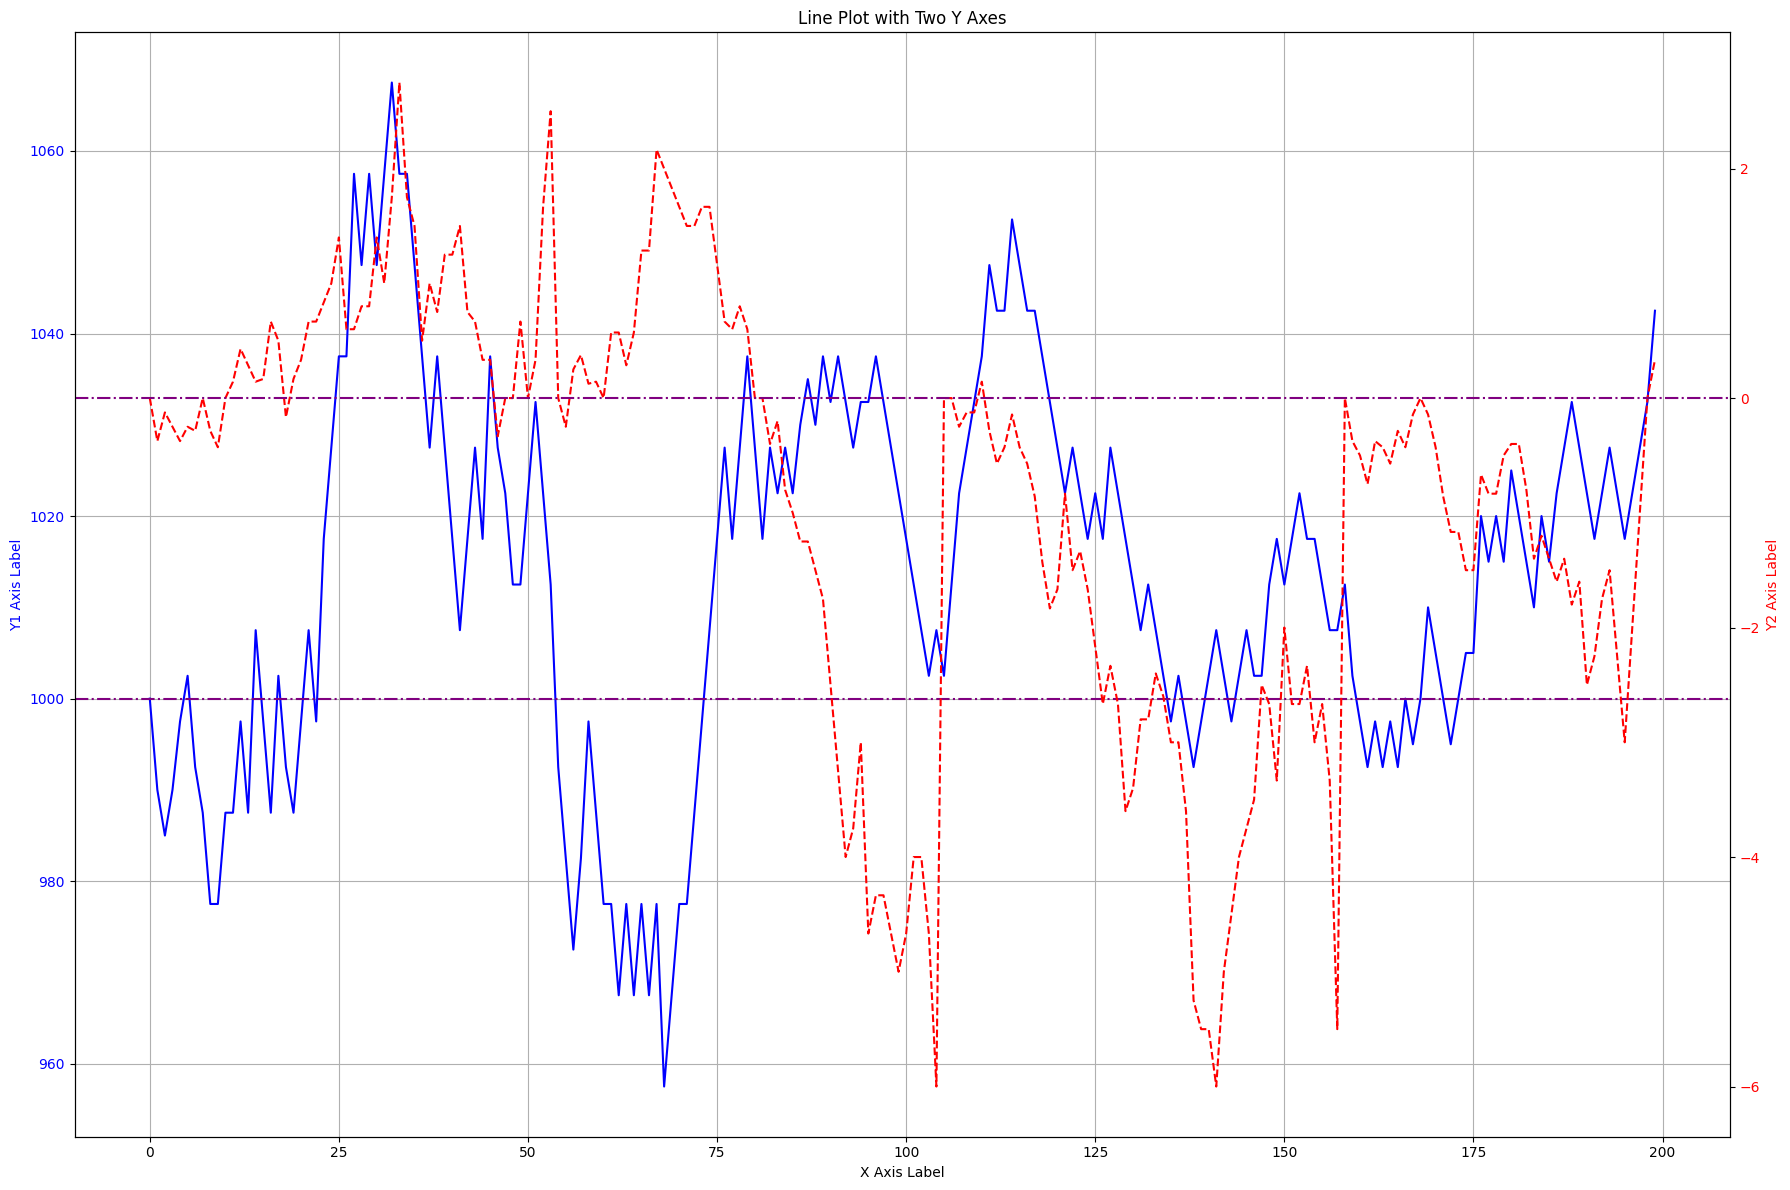

In [163]:
fig, ax1 = plt.subplots(figsize=(18, 12))
x = game.turns_number
y = game.funds_amount
y2 = game.deck_count

# First line plot using the first y-axis
ax1.plot(x, y, linestyle='-', color='blue', label='Y1 Data')
ax1.set_xlabel('X Axis Label')
ax1.set_ylabel('Y1 Axis Label', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.axhline(y=1000, color='purple', linestyle='-.', label='Horizontal Line at y1=0')
ax1.grid(True)

# Second line plot using a second y-axis
ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
ax2.plot(x, y2, linestyle='--', color='red', label='Y2 Data')
ax2.set_ylabel('Y2 Axis Label', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(y=0, color='purple', linestyle='-.', label='Horizontal Line at y2=0')


# Title and legend
plt.title('Line Plot with Two Y Axes')
fig.tight_layout()  # Adjust the layout to make room for the second y-axis

# Show the plot
plt.show()

In [164]:
results = []
for j in range(0,20):
    print(j)
    rules = Rules()
    game = Automation(rules = rules, player = Player(rules), dealer = Dealer(rules), num_of_decks = rules.num_of_decks, follow_strategy = 'jan', risk_strategy = 'none')
    game.turns(200,20,2000)

    results_game = []
    results_game.append(game.turns_number)
    results_game.append(game.funds_amount)
    results_game.append(game.deck_count)
    results_game.append(game.total_funding)
    results_game.append(game.earnings)

    results.append(results_game)

0
round 0 of 200
bet: 20
true count: 0
Player Cards hand 0: [Ace of Diamonds, King of Hearts]
Dealer Cards: [4 of Spades, 7 of Hearts, 9 of Hearts]
wins: 50.0
xxxxxxxxxxxxxxxxxxxxxx
player stands hand 0, Player cards: [Ace of Diamonds, King of Hearts], Dealer cards: [4 of Spades, 7 of Hearts, 9 of Hearts]
swing: 30.0
round 1 of 200
Hi-Lo
bet: 10.0
true count: -0.125
player hits hand 0, Player cards: [2 of Hearts, 3 of Diamonds], Dealer cards: [Ace of Hearts, 4 of Diamonds]
player hits hand 0, Player cards: [2 of Hearts, 3 of Diamonds, 4 of Clubs], Dealer cards: [Ace of Hearts, 4 of Diamonds]
player stands hand 0, Player cards: [2 of Hearts, 3 of Diamonds, 4 of Clubs, Ace of Hearts], Dealer cards: [Ace of Hearts, 4 of Diamonds]
Player Cards hand 0: [2 of Hearts, 3 of Diamonds, 4 of Clubs, Ace of Hearts]
Dealer Cards: [Ace of Hearts, 4 of Diamonds, 5 of Clubs]
wins: 10.0
xxxxxxxxxxxxxxxxxxxxxx
swing: 0.0
round 2 of 200
Hi-Lo
bet: 20
true count: 0.25
player hits hand 0, Player cards: [Jac

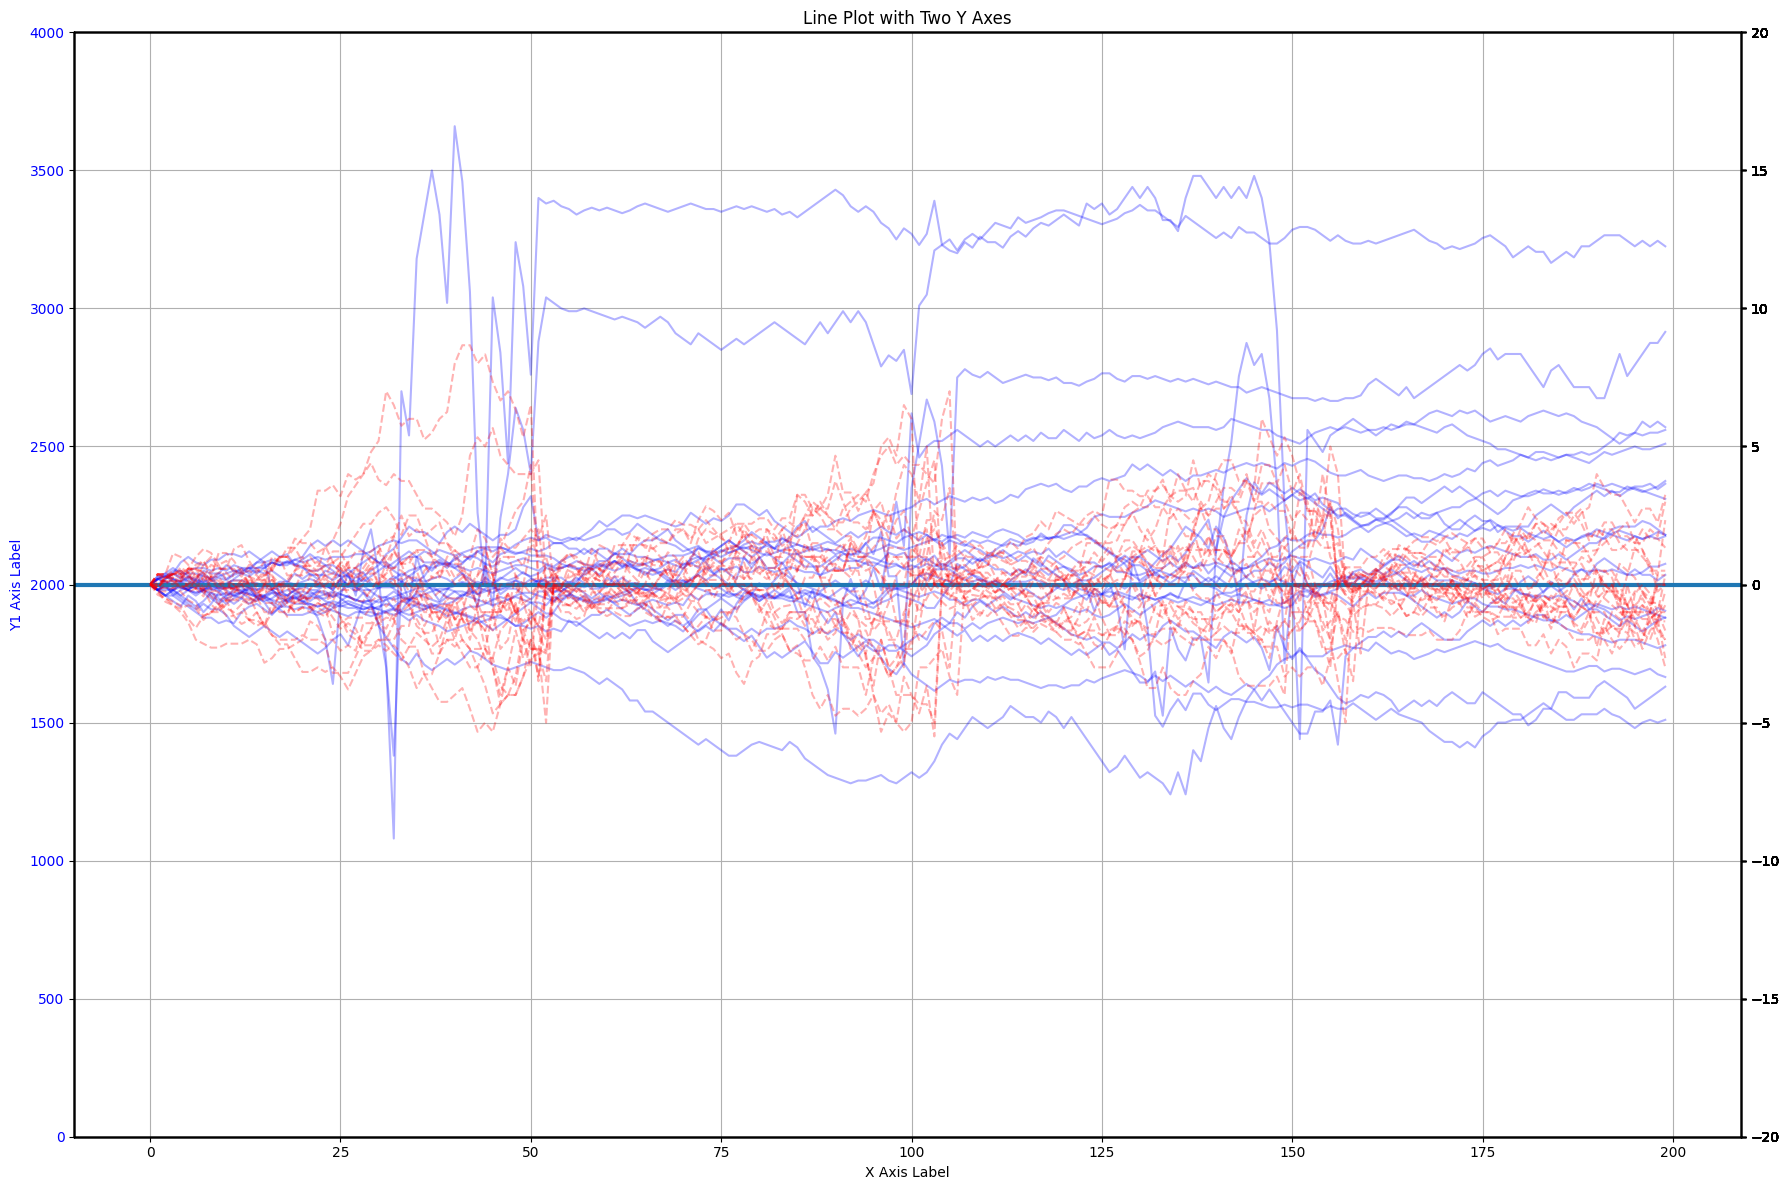

In [165]:
fig, ax1 = plt.subplots(figsize=(18, 12))
earnings = 0
funding = 0
for result in results:
    x = result[0]
    y = result[1]
    y2 = result[2]
    earnings += result[4]
    funding += result[3]

    # First line plot using the first y-axis
    ax1.plot(x, y, linestyle='-', color='blue', label='Y1 Data', alpha = 0.3)
    ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
    ax2.plot(x, y2, linestyle='--', color='red', label='Y2 Data', alpha = 0.3)
    ax1.set_ylim(0,4000)
    ax2.set_ylim(-20,20)
ax1.axhline(2000, linewidth = 3)
ax1.set_xlabel('X Axis Label')
ax1.set_ylabel('Y1 Axis Label', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)


# Title and legend
plt.title('Line Plot with Two Y Axes')
fig.tight_layout()  # Adjust the layout to make room for the second y-axis

# Show the plot
plt.show()

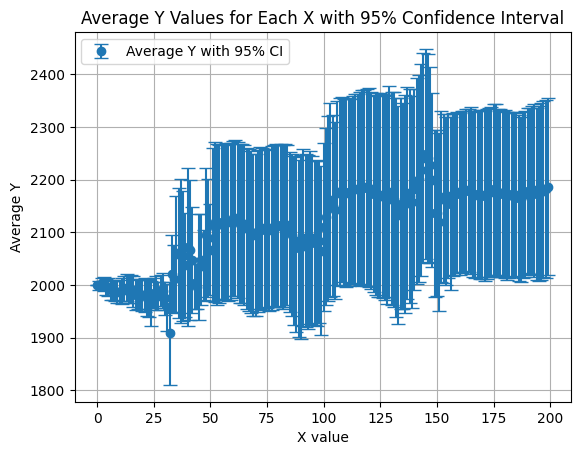

In [172]:
data = [[result[0],result[1]] for result in results]

# Extract all y-values (assuming all x-values are the same and consistent across data sets)
y_values = [dataset[1] for dataset in data]

# Transpose the y-values to align them by their x-index
transposed_y = list(zip(*y_values))

# Calculate the mean and the 95% confidence interval for each group of y-values
means = [np.mean(group) for group in transposed_y]
sample_sizes = [len(group) for group in transposed_y]
standard_deviations = [np.std(group, ddof=1) for group in transposed_y]  # ddof=1 for sample standard deviation

# t-values for 95% confidence interval
t_values = [t.ppf(0.95, df=n-1) for n in sample_sizes]

# Confidence intervals
conf_intervals = [t_val * (sd / np.sqrt(n)) for t_val, sd, n in zip(t_values, standard_deviations, sample_sizes)]

# X values (0 to 50)
x_values = data[0][0]

# Plotting
plt.errorbar(x_values, means, yerr=conf_intervals, fmt='o', capsize=5, label='Average Y with 95% CI')
plt.xlabel('X value')
plt.ylabel('Average Y')
plt.title('Average Y Values for Each X with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

In [169]:
earnings

43690.0

In [170]:
funding

46000

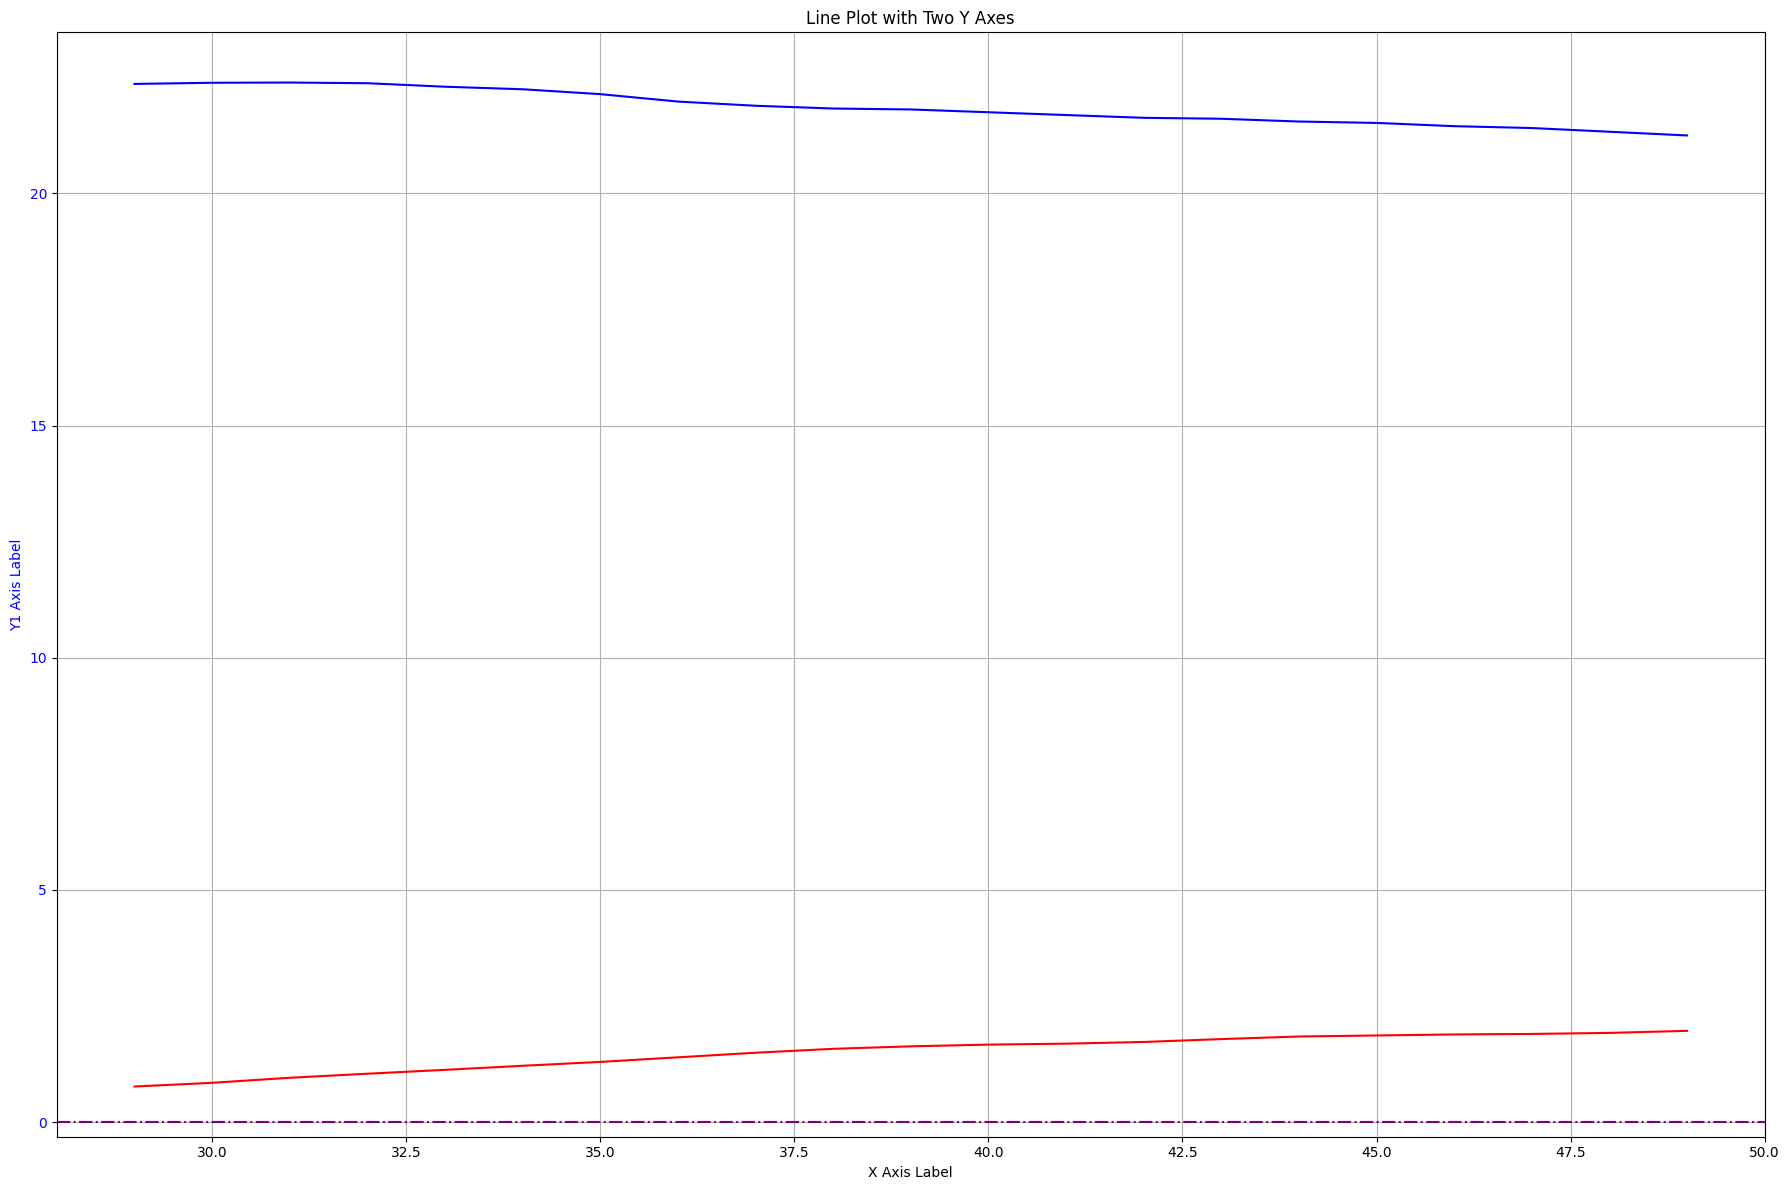

In [157]:
fig, ax1 = plt.subplots(figsize=(18, 12))
x = game.turns_number
y = game.funds_amount
y2 = game.deck_count
transformed_list = [(x - 1000)/50 for x in game.funds_amount]

series = pd.Series(y)
moving_avg_funds = series.rolling(window=30).mean().tolist()

series = pd.Series(y2)
moving_avg_count = series.rolling(window=30).mean().tolist()

series = pd.Series(transformed_list)
moving_avg_funds_damped = series.rolling(window=30).mean().tolist()

# First line plot using the first y-axis
#ax1.plot(x, y, linestyle='-', color='blue', label='Y1 Data')
ax1.plot(x, moving_avg_funds_damped, linestyle='-', color='blue', label='Y1 Data')
ax1.plot(x, moving_avg_count, linestyle ='-', color = 'red', label = 'Y2 Data')
ax1.set_xlabel('X Axis Label')
ax1.set_ylabel('Y1 Axis Label', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.axhline(y=0, color='purple', linestyle='-.', label='Horizontal Line at y2=0')
ax1.grid(True)

# Second line plot using a second y-axis
#ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
#ax2.plot(x, y2, linestyle='--', color='red', label='Y2 Data')
#ax2.plot(x, moving_avg_count, linestyle='-', color='red', label='Y2 Data')
#ax2.set_ylabel('Y2 Axis Label', color='red')
#ax2.tick_params(axis='y', labelcolor='red')
#ax2.axhline(y=0, color='purple', linestyle='-.', label='Horizontal Line at y2=0')


# Title and legend
plt.title('Line Plot with Two Y Axes')
fig.tight_layout()  # Adjust the layout to make room for the second y-axis

# Show the plot
plt.show()

In [49]:
from scipy.stats import pearsonr

In [50]:
correlation, _ = pearsonr(moving_avg_funds_damped[50:], moving_avg_count[50:])
correlation

np.float64(-0.1921422674366151)

In [51]:
transformed_list = [(x - 1000)/50 for x in game.funds_amount]

In [1]:
# Link: https://www.math4all.es/the-mathematics-of-blackjack/#estudio
# Link: https://probability.infarom.ro/blackjack.html

# Class Strategy Chart
    # initiate this class in every turn and override player options
    # only initiate when app.automate == True

    # def get_dealer_cards
        #score
    
    # def get_player_cards
        #score
    
    # if same player card ranks:
        # lookup split table
    
    # elif ace included:
        # lookup soft table
    
    # else:
        # lookup hard table

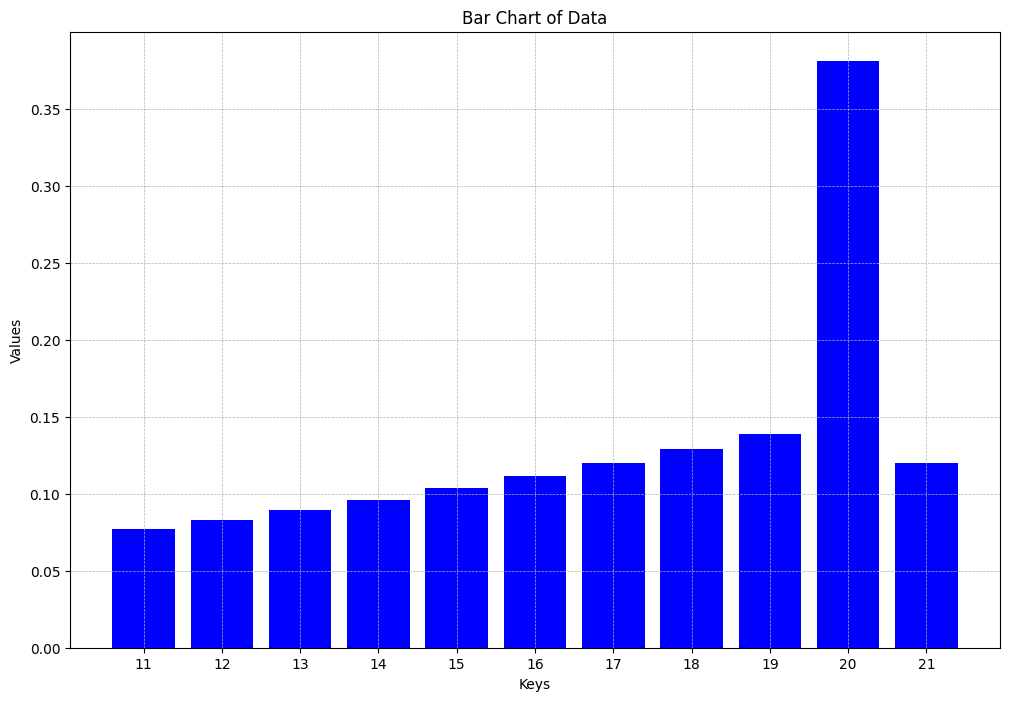

In [28]:
# List of integers
game_deck = Deck(8)
list_data = [x.card_scores[0] for x in game_deck.cards]

def simulate_draws(list_data, threshold, start_value):
    np.random.shuffle(list_data)
    cumulative_sum = start_value
    values = []
    results = []
    for number in list_data:
        if any(x in [1,11] for x in values):
            if sum(values) < 10 and 1 in values:
                values.remove(1)
                values.append(11)
            elif sum(values) > 21 and 11 in values:
                values.remove(11)
                values.append(1)
        cumulative_sum += number
        values.append(number)
        results.append(cumulative_sum)
        if cumulative_sum > threshold:
            results = results[:-1]
            return results

# Number of simulations
n_simulations = 10000000
results_all = [simulate_draws(lst.copy(), 21, 10) for _ in range(n_simulations)]
results_all_flat = [item for sublist in results_all for item in sublist]
# Calculate probability distribution
counts = Counter(results_all_flat)
probabilities = {x: count / n_simulations for x, count in counts.items()}

# Display results
sorted_probabilities = sorted(probabilities.items(), key=lambda item: item[1])

# Unpacking the data
x, y = zip(*sorted_probabilities)

# Creating a bar chart
plt.figure(figsize=(12, 8))  # Adjust the figure size as necessary
plt.bar(x, y, color='blue')  # You can change the color
plt.xlabel('Keys')  # Label for the x-axis
plt.ylabel('Values')  # Label for the y-axis
plt.title('Bar Chart of Data')  # Title of the chart
plt.xticks(x)  # Ensure all x-labels are shown
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid lines for better readability
plt.show()

### Strategy Chart

In [32]:
import numpy as np

# Constants
SUITS = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
RANKS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
VALUES = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}

def shuffle_deck():
    """Returns a shuffled deck of cards, excluding specified initial cards."""
    deck = [(rank, suit) for rank in RANKS for suit in SUITS]
    np.random.shuffle(deck)
    return deck

def hand_value(hand):
    """Returns the value of a blackjack hand."""
    value = sum(VALUES[card[0]] for card in hand)
    # Adjust for Aces
    num_aces = sum(1 for card in hand if card[0] == 'A')
    while value > 21 and num_aces:
        value -= 10
        num_aces -= 1
    return value

def should_player_hit(hand, dealer_card):
    """Determines if the player should hit based on a simple version of blackjack strategy."""
    player_value = hand_value(hand)
    dealer_value = VALUES[dealer_card[0]]
    
    # Basic strategy decisions can be more complex, this is a simplified version
    if player_value < 12:
        return True
    elif player_value == 12 and dealer_value in [2, 3]:
        return True
    elif 12 < player_value < 17 and dealer_value > 6:
        return True
    return False

def play_dealer_hand(deck, initial_card):
    """Plays the dealer's hand starting with the initial card and returns the final hand and its value."""
    hand = [initial_card, deck.pop()]
    while hand_value(hand) < 17:
        hand.append(deck.pop())
    return hand, hand_value(hand)

def play_blackjack_game(dealer_card, player_cards):
    """Simulates a single game of blackjack given initial cards and returns the result."""
    deck = shuffle_deck()
    # Remove the initial cards from the deck
    deck = [card for card in deck if card not in [dealer_card, *player_cards]]
    
    # Play player's hand based on basic strategy
    while should_player_hit(player_cards, dealer_card):
        player_cards.append(deck.pop())
    
    player_value = hand_value(player_cards)
    dealer_hand, dealer_value = play_dealer_hand(deck, dealer_card)

    if player_value > 21:
        return 'lose'  # Player busts
    if dealer_value > 21:
        return 'win'   # Dealer busts
    if player_value > dealer_value:
        return 'win'
    elif player_value == dealer_value:
        return 'push'
    else:
        return 'lose'

def simulate_blackjack_games(dealer_card, player_cards, n=1000000):
    """Simulate n games of blackjack with given initial cards and report probabilities of outcomes."""
    results = {'win': 0, 'push': 0, 'lose': 0}
    for _ in range(n):
        result = play_blackjack_game(dealer_card, player_cards)
        results[result] += 1

    total_games = sum(results.values())
    print(f"After {total_games} games with dealer starting with {dealer_card} and player with {player_cards}:")
    print(f"Player wins: {results['win'] / total_games:.2%}")
    print(f"Push: {results['push'] / total_games:.2%}")
    print(f"Player loses: {results['lose'] / total_games:.2%}")

# Example of input cards
dealer_card = ('8', 'Spades')  # Dealer's visible card
player_cards = [('8', 'Hearts'), ('2', 'Diamonds')]  # Player's cards

# Run the simulation with specific cards and basic strategy
simulate_blackjack_games(dealer_card, player_cards)

After 1000000 games with dealer starting with ('8', 'Spades') and player with [('8', 'Hearts'), ('2', 'Diamonds'), ('9', 'Spades')]:
Player wins: 73.26%
Push: 13.36%
Player loses: 13.38%


In [42]:
from collections import Counter

def calculate_dealer_outcomes(dealer_start_score, deck):
    outcomes = Counter()
    if dealer_start_score > 21:
        outcomes['bust'] = 1
    elif dealer_start_score >= 17:
        outcomes[dealer_start_score] = 1
    else:
        for card, count in deck.items():
            if count > 0:
                new_score = dealer_start_score + card
                new_deck = deck.copy()
                new_deck[card] -= 1
                for outcome, prob in calculate_dealer_outcomes(new_score, new_deck).items():
                    outcomes[outcome] += prob * (count / sum(deck.values()))
    return outcomes

def calculate_ev(player_score, dealer_up_card):
    if player_score > 21:
        return -1  # Player busts
    
    # Define a simplified deck
    full_deck = Deck(8)
    deck = Counter()
    for card in full_deck.cards:
        if card.rank in [10,11,12,13]:
            deck[10] += 1
        elif card.rank == 1:
            deck[11] += 1
        else:
            deck[card.rank] += 1  # Simplified deck counts for multiple decks
    deck[dealer_up_card] -= 1  # Remove the dealer's up card from the deck

    # Calculate dealer outcomes starting from dealer's up card
    dealer_outcomes = calculate_dealer_outcomes(dealer_up_card, deck)

    ev = 0
    for outcome, probability in dealer_outcomes.items():
        if outcome == 'bust':
            ev += 1 * probability  # Dealer busts, player wins
        elif outcome != 'bust' and player_score > outcome:
            ev += 1 * probability  # Player score is higher, player wins
        elif outcome != 'bust' and player_score < outcome:
            ev += -1 * probability  # Player score is lower, player loses

    return ev

def background_color(val):
    """
    Applies background color to DataFrame cells based on their value.
    """
    if val < -0.1:
        color = 'green'
    else:
        color = 'red'
    return f'background-color: {color}'


dealer_up_cards = [2,3,4,5,6,7,8,9,10,11]
player_scores = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
chart = pd.DataFrame(index = player_scores, columns = dealer_up_cards)
for dealer_up_card in dealer_up_cards:
    for player_score in player_scores:
        ev = calculate_ev(player_score, dealer_up_card)
        chart.loc[player_score, dealer_up_card] = ev

chart
# Apply the style function to the DataFrame
styled_chart = chart.style.applymap(background_color)

# Display the styled DataFrame in a Jupyter notebook
styled_chart

C:\Users\JanAllemann\AppData\Local\Temp\ipykernel_20568\3090057081.py:70: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_chart = chart.style.applymap(background_color)


,2,3,4,5,6,7,8,9,10,11
5,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
6,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
7,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
8,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
9,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
10,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
11,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
12,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
13,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
14,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791


In [43]:
from collections import Counter
import pandas as pd

class Deck:
    def __init__(self, num_decks):
        self.cards = [rank for rank in range(1, 14)] * 4 * num_decks  # Create a deck with ranks 1-13 (1 is Ace)

def calculate_dealer_outcomes(dealer_start_score, deck):
    outcomes = Counter()
    if dealer_start_score > 21:
        outcomes['bust'] = 1
    elif dealer_start_score >= 17:
        outcomes[dealer_start_score] = 1
    else:
        for card, count in deck.items():
            if count > 0:
                new_score = dealer_start_score + card
                new_deck = deck.copy()
                new_deck[card] -= 1
                for outcome, prob in calculate_dealer_outcomes(new_score, new_deck).items():
                    outcomes[outcome] += prob * (count / sum(deck.values()))
    return outcomes

def player_options(player_score, dealer_up_card, deck):
    if player_score > 21:
        return -1  # Player busts
    
    # Stand scenario: calculate EV based on current score against dealer outcomes
    stand_ev = calculate_ev(player_score, dealer_up_card, deck.copy(), False)
    
    # Hit scenario: calculate EV by drawing another card
    if player_score <= 21:
        hit_ev = 0
        remaining_cards = sum(deck.values())
        for card, count in deck.items():
            if count > 0:
                new_deck = deck.copy()
                new_deck[card] -= 1
                new_score = player_score + (10 if card == 11 else card)
                hit_ev += (player_options(new_score, dealer_up_card, new_deck) * count) / remaining_cards
    else:
        hit_ev = stand_ev  # If bust, hit EV is the same as stand EV

    return max(stand_ev, hit_ev)  # Return the higher EV of hitting or standing

def calculate_ev(player_score, dealer_up_card, deck, simulate_player=True):
    if not simulate_player:
        # Dealer scenario
        dealer_outcomes = calculate_dealer_outcomes(dealer_up_card, deck)
        ev = 0
        for outcome, probability in dealer_outcomes.items():
            if outcome == 'bust':
                ev += 1 * probability  # Dealer busts, player wins
            elif outcome != 'bust' and player_score > outcome:
                ev += 1 * probability  # Player score is higher, player wins
            elif outcome != 'bust' and player_score < outcome:
                ev += -1 * probability  # Player score is lower, player loses
        return ev
    else:
        return player_options(player_score, dealer_up_card, deck)

# Define and fill the DataFrame
dealer_up_cards = [2,3,4,5,6,7,8,9,10,11]
player_scores = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
chart = pd.DataFrame(index=player_scores, columns=dealer_up_cards)
full_deck = Deck(8)  # Assume using 8 decks

for dealer_up_card in dealer_up_cards:
    deck = Counter()
    for card in full_deck.cards:
        if card in [10, 11, 12, 13]:
            deck[10] += 1
        elif card == 1:
            deck[11] += 1
        else:
            deck[card] += 1
    deck[dealer_up_card] -= 1  # Remove dealer's up card
    
    for player_score in player_scores:
        ev = calculate_ev(player_score, dealer_up_card, deck)
        chart.at[player_score, dealer_up_card] = ev

# Apply style
def background_color(val):
    if val < -0.1:
        return 'background-color: green'
    elif val > 0.1:
        return 'background-color: red'
    else:
        return 'background-color: yellow'

styled_chart = chart.style.applymap(background_color)
styled_chart

C:\Users\JanAllemann\AppData\Local\Temp\ipykernel_20568\1341890956.py:92: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_chart = chart.style.applymap(background_color)


,2,3,4,5,6,7,8,9,10,11
5,-0.045473,-0.012945,0.019966,0.060059,0.055908,-0.171891,-0.238572,-0.309669,-0.385459,-0.356546
6,-0.056718,-0.023823,0.009430,0.049798,0.045926,-0.202413,-0.260028,-0.324352,-0.397735,-0.366115
7,-0.027644,0.004123,0.036571,0.075418,0.080443,-0.103689,-0.243250,-0.302079,-0.376287,-0.344035
8,0.051816,0.080790,0.112124,0.145321,0.159253,0.067773,-0.094144,-0.238949,-0.309894,-0.281126
9,0.142224,0.169909,0.196672,0.227462,0.237806,0.162665,0.086452,-0.081493,-0.236873,-0.206083
10,0.237425,0.260786,0.284543,0.312233,0.320089,0.239865,0.181820,0.099880,-0.078867,-0.132222
11,0.388072,0.406956,0.426033,0.448180,0.453932,0.376617,0.319029,0.255617,0.161300,0.087435
12,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.271123,-0.326026,-0.387996,-0.456166,-0.464277
13,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.320181,-0.371711,-0.424583,-0.492474,-0.470791
14,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.366218,-0.409332,-0.463295,-0.527934,-0.470791


C:\Users\JanAllemann\AppData\Local\Temp\ipykernel_20568\1738485628.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_chart = chart.style.applymap(background_color)


,2,3,4,5,6,7,8,9,10,11
5,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
6,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
7,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
8,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
9,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
10,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
11,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
12,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
13,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
14,-0.172672,-0.135706,-0.098479,-0.052294,-0.064132,-0.425184,-0.464965,-0.497152,-0.538899,-0.470791
